# Fairness Metrics

<h2>Learning Objectives:</h2>

- Gain experience in implementing and using fairness metrics
- To investigate gaining insights into the fairness of data-driven decision making algorithms 
- To critically appraise varied metrics in their use and limitations in measuring fairness

<h3>Fairness Metrics  - Group Fairness</h3>

Focus is on a small number of fairness metrics and test the effectiveness of a fairness through unawareness strategy.

- Demographic Parity 
- Equalised Odds [1]
- Equal Opportunity [1]
- Fairness Through Unawareness

[1] M. Hardt, E. Price, and N. Srebro, “Equality of Opportunity in Supervised Learning,” 2016.
    

In [1]:
import sys
import os
from platform import python_version 

#------------- Load in some helpful packages -------------------------

import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay


from sklearn.model_selection import train_test_split # randomly split data into test and train
from sklearn.ensemble import RandomForestClassifier # import classifier from sklearn 
from sklearn.neural_network import MLPClassifier  # import classifier from sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import tree
from sklearn.preprocessing import StandardScaler, LabelEncoder


#------------- Print versions an paths for potencial debugging -------------------------

print('Python version:', python_version()) # print the version of python the script is using
print('Python path:', sys.executable) # print the path for the python executable the script is using
print('Working Directory:', os.getcwd()) # print the current working directory 


Python version: 3.11.5
Python path: c:\Users\hgnis\anaconda3\python.exe
Working Directory: d:\ProgrammingSpaceMain\abuses-biases-in-dataTEMP\FairML\lab5


# 1. Build classifier to predict $\hat{Y}$


## 1.1 Load Data Set

The dataset is the German Credit data - it has 20 Attributes (7 numerical, 13 categorical). It contains various information about each applicant that is applying for a loan for example: salary paid in, years in employment, years in current address, loan amount etc. You can read about all the attributes in the data folder from the lab download in the data folder there is a word file called 'german_data_description.doc'.

Couple of things to note: 

- The original data set comes with a cost matrix (for the loan decision). Here it's simplifed to a ground truth label of the loan should be issued or not $Y = y, y \in {0,1}$.
   - This data is in an additional column in the data set named `classification`.
- The attributes contain explicit information on the sex and marital status of the loan applicant, in an attribute named `statussex`.

In [2]:
names = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']

data = pd.read_csv("data/german.data", delimiter=' ', names = names )

data.classification.replace([1,2], [1,0], inplace=True)

## 1.2 Pre-process data

- normalising the numerical values
- converting categorical values to numbers (needed for some classifiers)
- save the data in new dataframe `clean_data`.


In [3]:
#numerical variables labels
numvars = ['creditamount', 'duration', 'installmentrate', 'residencesince', 'age', 
           'existingcredits', 'peopleliable', 'classification']

# Normilisation
numdata_std = pd.DataFrame(StandardScaler().fit_transform(data[numvars].drop(['classification'], axis=1)))

from collections import defaultdict

#categorical variables labels
catvars = ['existingchecking', 'credithistory', 'purpose', 'savings', 'employmentsince',
           'statussex', 'otherdebtors', 'property', 'otherinstallmentplans', 'housing', 'job', 
           'telephone', 'foreignworker']

d = defaultdict(LabelEncoder)

# Encoding the variable
lecatdata = data[catvars].apply(lambda x: d[x.name].fit_transform(x))

#combine data into one clean data set
data_clean = pd.concat([data[numvars], lecatdata], axis = 1)

In [4]:
#1. print shape of the clean data
print(data_clean.shape)

#2. view the data
data_clean.head()

(1000, 21)


,creditamount,duration,installmentrate,residencesince,age,existingcredits,peopleliable,classification,existingchecking,credithistory,...,savings,employmentsince,statussex,otherdebtors,property,otherinstallmentplans,housing,job,telephone,foreignworker
0,1169,6,4,4,67,2,1,1,0,4,...,4,4,2,0,0,2,1,2,1,0
1,5951,48,2,2,22,1,1,0,1,2,...,0,2,1,0,0,2,1,2,0,0
2,2096,12,2,3,49,1,2,1,3,4,...,0,3,2,0,0,2,1,1,0,0
3,7882,42,2,4,45,1,2,1,0,2,...,0,3,2,2,1,2,2,2,0,0
4,4870,24,3,4,53,2,2,0,0,3,...,0,2,2,0,3,2,2,2,0,0


## 1.3 Create Train and Test Data Sets


In [5]:
X_clean = data_clean.drop('classification', axis=1)
y_clean = data_clean['classification']
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean,y_clean,test_size=0.2, random_state=1)

class_names = ['Loan Refused (negative)', 'Loan Granted (positive)'] # used later to lable confusion matrices
print(X_train_clean.columns)


Index(['creditamount', 'duration', 'installmentrate', 'residencesince', 'age',
       'existingcredits', 'peopleliable', 'existingchecking', 'credithistory',
       'purpose', 'savings', 'employmentsince', 'statussex', 'otherdebtors',
       'property', 'otherinstallmentplans', 'housing', 'job', 'telephone',
       'foreignworker'],
      dtype='object')


## 1.4 Train and Test Classifier

In [6]:
model = RandomForestClassifier(n_estimators=100, random_state=1, max_depth=5).fit(X_train_clean, y_train_clean)

pred_val_y = model.predict(X_test_clean)

## 1.5 Plot the Results of the Classifier


In [ ]:

#1. calc acc
acc = accuracy_score(y_test_clean, pred_val_y)

#2. calc f1
f1 = f1_score(y_test_clean, pred_val_y)

print('\nModel accuracy = ', acc)
print('Model f1 score = ', f1)


Model accuracy =  0.755
Model f1 score =  0.848297213622291


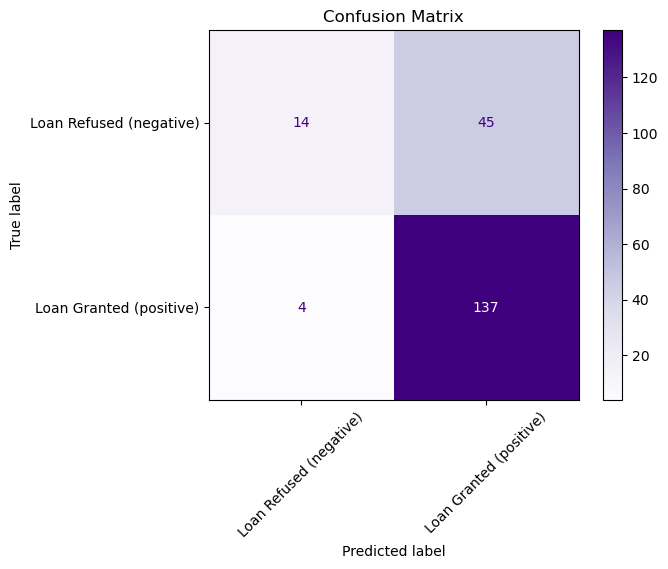

In [8]:
cm = confusion_matrix(y_test_clean, pred_val_y, labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp = disp.plot(cmap='Purples',values_format = '.0f')
plt.xticks(rotation=45)
plt.title('Confusion Matrix');
plt.show()

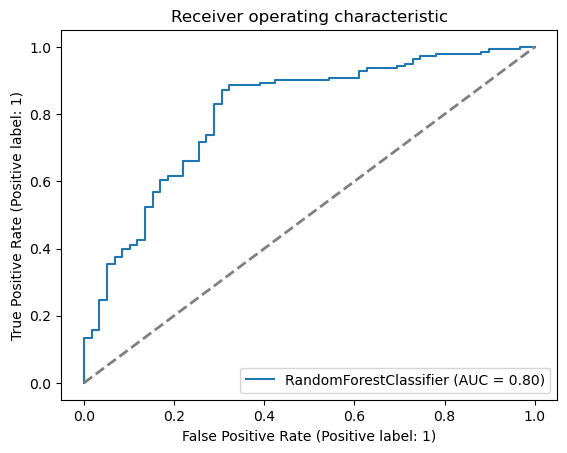

In [9]:
RocCurveDisplay.from_estimator(model, X_test_clean, y_test_clean)

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.title('Receiver operating characteristic')
plt.show() 

### 1.5.1 Classifier Results by Sex


In [10]:
test_results = X_test_clean.merge(y_test_clean, left_index=True, right_index=True)
test_results['pred_Y'] = pred_val_y

def label_sex(row):
    if row['statussex'] == 0 or row['statussex'] == 2 or row['statussex'] == 3:
        return(1)
    if row['statussex'] == 1:
        return(0) 

# crete new coloumn to denote sex in results
test_results['Sex_code'] = test_results.apply (lambda row: label_sex(row), axis=1)


#1. set varible to column names that 
A = 'Sex_code'
Y_hat = 'pred_Y'
Y = 'classification'

#2. view dataframe
test_results

,creditamount,duration,installmentrate,residencesince,age,existingcredits,peopleliable,existingchecking,credithistory,purpose,...,otherdebtors,property,otherinstallmentplans,housing,job,telephone,foreignworker,classification,pred_Y,Sex_code
507,6850,15,1,2,34,1,2,1,1,0,...,0,1,2,1,3,1,0,0,1,1
818,15857,36,2,3,43,1,1,0,2,2,...,1,2,2,1,3,0,0,1,0,1
452,2759,12,2,4,34,2,1,3,0,3,...,0,1,2,1,2,0,0,1,1,1
368,3446,36,4,2,42,1,2,0,2,3,...,0,2,2,1,2,0,0,0,1,1
242,4605,48,3,4,24,2,2,0,0,1,...,0,3,2,2,2,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,3448,5,1,4,74,1,1,3,2,9,...,0,0,2,1,1,0,0,1,1,1
874,3590,12,2,2,29,1,2,0,2,3,...,1,1,2,1,1,0,0,1,1,1
550,996,12,4,4,23,2,1,3,4,6,...,0,0,2,1,2,0,0,1,1,0
608,2051,18,4,1,33,1,1,3,2,4,...,0,0,2,1,2,0,0,1,1,1


### 1.5.2 Investigating the output.

In this section you will investigate the output table this skills will help later in calculating Fairness metrics by counting True positives, False Negatives, number of males females etc. To do this below is a a reminder on dataframes is illustrated on figure 2. Furthermore you can access specific columns and rows in the dataframe at any one time. For example:

- you can count the number of rows in a dataframe using `len(df)`
- you can view only rows with specific attributes using `df[(df['Sex_code'] == 1)]` 
    - combine the above to count number of males.
    - you can logically combine indexing for example male and existing credits is two. 
        - `test_results[(test_results['Sex_code'] == 1) & (test_results['existingcredits'] == 2)]`
- you can view the data in the 'creditamount' column only `df['creditamount']`


<center><img src="images/finallpandas.png" style="width:500px;"></center>
<caption><center><i> <b>Figure 2:</b> Pandas DataFrame  is two-dimensional tabular data structure with labeled axes and consists of three principal components, the <font color='purple'><b>data</b></font>, <font color='orange'><b>rows</b></font>, and <font color='blue'><b>columns</b></font>.</i> </center></caption>

**Optional information** see data geeks for simple explanation and source of Figure 2 https://www.geeksforgeeks.org/python-pandas-dataframe/#. Alternatively you can visit the official Pandas DataFrame usage page https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html


**Your task is to:**


- Count the number of males in the test set
- Count the number of females in the test set that have one exiting loan
- View the data in three specific columns in `test_results` dataframe
    - sensitive attribute $A$,  `A`
    - predicted outcome $\hat{Y}$,  `Y_hat`
    - actual outcome $Y$,  `Y`


**Note** Where appropriate use your variables not column names.

In [11]:
### START CODE ####

#1.count males
num_males = test_results.loc[test_results[A] == 1].shape[0]

print('num_males',num_males)


#2. count female with one exsiting credit
num_female_credit = test_results.loc[test_results[A] == 0].loc[test_results['existingcredits'] == 1].shape[0]

print('num_female_credit',num_female_credit)


#3. edit code to view different data columns
test_results['creditamount']


### END CODE ###

num_males 147
num_female_credit 36


507     6850
818    15857
452     2759
368     3446
242     4605
       ...  
430     3448
874     3590
550      996
608     2051
207     1424
Name: creditamount, Length: 200, dtype: int64

### 1.5.2 Create data frames for male and females

Separate data frames for male and females to make the generation of the confusion matrices and ROC plots more simple. 

In [12]:
male_test_results = test_results[(test_results[A] == 1)]

female_test_results = test_results[(test_results[A] == 0)]

male_X_clean = male_test_results.drop(['classification', 'pred_Y','Sex_code'], axis=1)

female_X_clean = female_test_results.drop(['classification', 'pred_Y','Sex_code'], axis=1)

#1. calc male acc
male_acc = accuracy_score(male_test_results[Y], male_test_results[Y_hat])

#2. calc male f1
male_f1 = f1_score(male_test_results[Y], male_test_results[Y_hat])

print('\nModel accuracy (males) = ', male_acc)
print('Model f1 score (males) = ', male_f1)


Model accuracy (males) =  0.7755102040816326
Model f1 score (males) =  0.8630705394190872


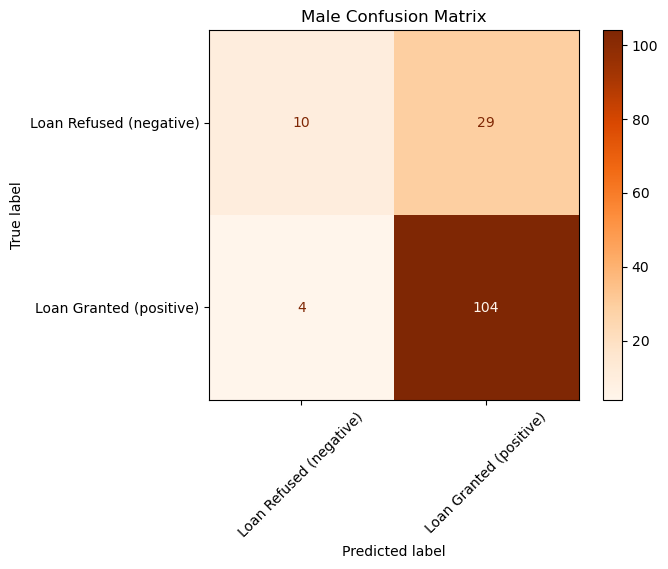

In [13]:
cm = confusion_matrix(male_test_results[Y], male_test_results[Y_hat], labels=model.classes_)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp = disp.plot(cmap='Oranges',values_format = '.0f')
plt.xticks(rotation=45)
plt.title('Male Confusion Matrix');
plt.show()

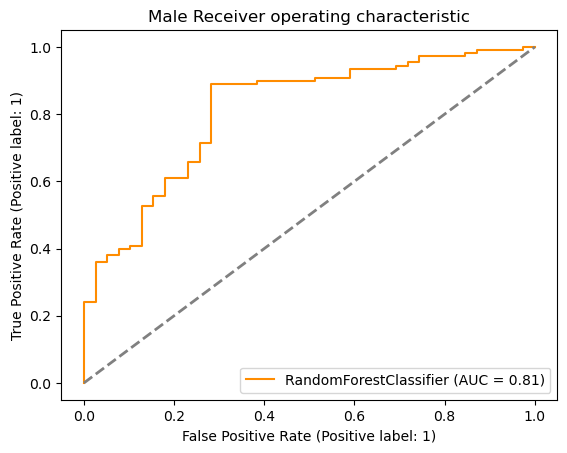

In [17]:
RocCurveDisplay.from_estimator(model, male_X_clean, male_test_results[Y], color='darkorange')

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.title('Male Receiver operating characteristic')
plt.show()

In [18]:
female_acc = accuracy_score(female_test_results[Y], female_test_results[Y_hat])

female_f1 = f1_score(female_test_results[Y], female_test_results[Y_hat])

print('\nModel accuracy (females) = ', female_acc)
print('Model f1 score (females) =', female_f1)


Model accuracy (females) =  0.6981132075471698
Model f1 score (females) = 0.8048780487804877


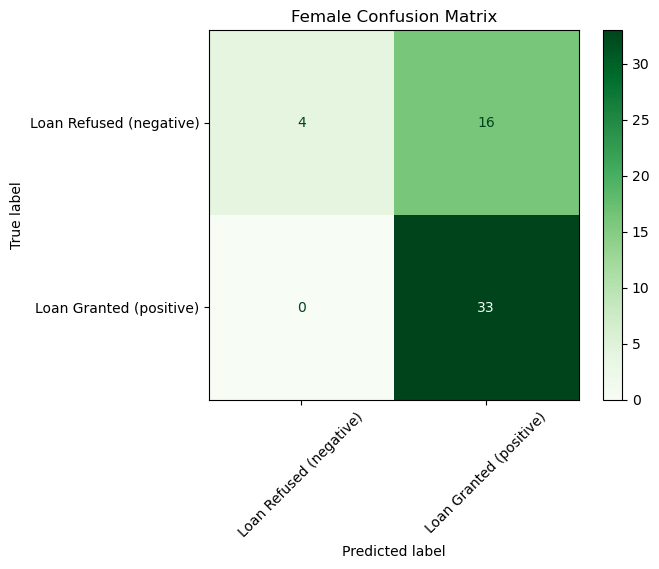

In [19]:
cm = confusion_matrix(female_test_results[Y], female_test_results[Y_hat], labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp = disp.plot(cmap='Greens',values_format = '.0f')
plt.xticks(rotation=45)
plt.title('Female Confusion Matrix');
plt.show()

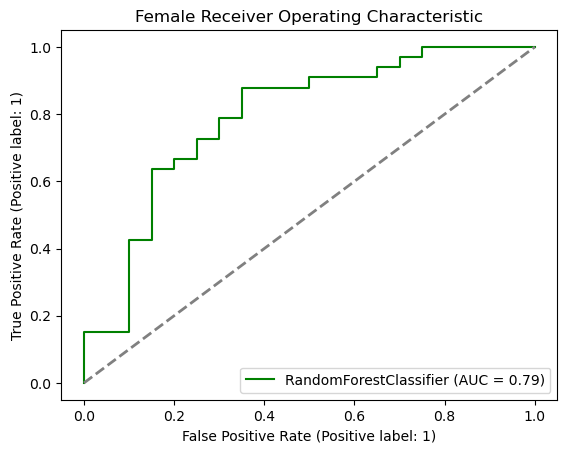

In [21]:
RocCurveDisplay.from_estimator(model, female_X_clean, female_test_results[Y], color='green')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.title('Female Receiver Operating Characteristic')
plt.show() 

# 2. Fairness Metrics

Protected characteristic to use will be sex (male, female). 


## 2.1 Demographic Parity

A common conception of non-discrimination is demographic parity requires that a decision - such as accepting or denying a loan application — be independent of the protected attribute. In the case of a binary decision $\hat{Y} \in {0,1}$ and a binary protected attribute $A \in {0,1}$, this constraint can be formalized by asking that:

$$ Pr(\hat{Y} = 1 | A = 0) = Pr(\hat{Y} = 1| A = 1) $$

In other words, membership in a protected class should have no correlation with the decision. Through its various equivalent formalizations this idea appears in numerous papers.

In [22]:
# 1. calc total tests
total_tests = len(test_results)

#2. calc male condition positive
male_CP = len(test_results[(test_results[A] == 1) & (test_results[Y_hat] == 1)])
Pr_male_CP = male_CP/total_tests

#3. calc female condition positive
female_CP = len(test_results[(test_results[A] == 0)  & (test_results[Y_hat] == 1)])
Pr_female_CP = female_CP/total_tests

#4. calc male condition negative
male_CN = len(test_results[(test_results[A] == 1) & (test_results[Y_hat] == 0)])
Pr_male_CN = male_CN/total_tests

#5. calc female condition negative
female_CN = len(test_results[(test_results[A] == 0) & (test_results[Y_hat] == 0)])
Pr_female_CN = female_CN / total_tests

#6. calc equality tests for both postive and negative condition
demo_equal_CP = male_CP == female_CP
demo_equal_CN = male_CN == female_CN

#7. test for demogrpahic parity (when both equal_CP and equal_CN are True)
demo_parity = demo_equal_CP & demo_equal_CN

print('Male Condition Positive probability = ',Pr_male_CP)
print('Female Condition Positive probability = ',Pr_female_CP)
print('Male Condition Negative probability = ',Pr_male_CN)
print('Female Condition Negative probability = ',Pr_female_CN)

print('Demographic Parity for Condition Positive is:',demo_equal_CP)
print('Demographic Parity for Condition Negative is:',demo_equal_CN)
print('Demographic Parity is:',demo_parity)



Male Condition Positive probability =  0.665
Female Condition Positive probability =  0.245
Male Condition Negative probability =  0.07
Female Condition Negative probability =  0.02
Demographic Parity for Condition Positive is: False
Demographic Parity for Condition Negative is: False
Demographic Parity is: False


### 2.1.1 Common Relaxation Techniques for Demographic Parity

There are two common relaxations of the strict definition of Demographic Parity. First we are often more interested in the positive condition in this case we need only to achieve parity on $\hat{Y} =1$. Second, from the US Civil Rights act of 1964 we have legal guidance with which we can relax the formal constraint of being exactly equal. The four-fifths or 80% rule is described by the guidelines as <i>“a selection rate for any race, sex, or ethnic group which is less than four-fifths (or 80%) of the rate for the group with the highest rate will generally be regarded by the Federal enforcement agencies as evidence of adverse impact, while a greater than four-fifths rate will generally not be regarded by Federal enforcement agencies as evidence of adverse impact."</i> Therefore we can re-define the constraint in the test (assume $A=1$ is the advantaged group) to:

$$ \frac{Pr(\hat{Y}=1, A=0)}{Pr(\hat{Y}=1, A=1)} \geq 1- \epsilon $$ 

In [23]:
#1. complete the function input parameters
def Relax_equal(epsilon , high_group, low_group):
    '''
    This function tests for a relaxed definition of 'equal to' and returns True or False
    
    Input:
    epsilon - a number to represent percentile within which the callsifer need to perform on the lower group in comparison to the higher group
    high_group - the performance metric of the classifer on the higher (advantaged) performing group
    low_group - the performance metric of the classifer on the lower (disadvantaged) performing group
    
    Output:
    relax_equal_to - Boolean state if 'equal to' met, True or False
    '''

    #2. calc demo ratio
    relax_ratio = low_group / high_group
    print('Ratio ',relax_ratio)
    if relax_ratio > 1:
        print('Error: Ratio (left of eqaution) grater than one = ', relax_ratio)
        print('Ensure that the higher performing group is passed first in the parameter list, then lower performing group')
        return(None)  # NOTE None should remain in this line.
    
    #3. write relaxed Demogrpahic parity test
    relax_equal_to = relax_ratio > (1-epsilon) and relax_ratio < (1+epsilon)
    
    
    #4. return test result
    return(relax_equal_to)

Sanity check:

- Case 1 where the classifier offers loans to 80% of men and 76% of women who apply. 
- Case 2 where the classifier offers loans to 88% of men and 73% of women who apply. 
- Case 3 where the classifier offers loans to 65% of men and 71% of women who apply.
- Case 4 where the classifier offers loans to 54% of men and 68% of women who apply.

Specifically the parameter to check to see if the classifier performance for the lower group is within 10% of the higher group.

In [24]:
print('Case 1 demographic parity = ', Relax_equal(0.1 , 0.8, 0.76) )
print('Case 2 demographic parity = ', Relax_equal(0.1 , 0.88, 0.73) )
print('Case 3 demographic parity = ', Relax_equal(0.1 , 0.71, 0.65) )
print('Case 4 demographic parity = ', Relax_equal(0.1 , 0.68, 0.54) )

Ratio  0.95
Case 1 demographic parity =  True
Ratio  0.8295454545454545
Case 2 demographic parity =  False
Ratio  0.915492957746479
Case 3 demographic parity =  True
Ratio  0.7941176470588235
Case 4 demographic parity =  False


In [26]:
#1. enter value for epsilon
epsilon = 0.1

#2. call function
test_result = Relax_equal(epsilon, male_CP, female_CP)

#3. print result of test
print('Demographic parity =', test_result)

Ratio  0.3684210526315789
Demographic parity = False


### 2.1.2 Problems with Demographic Parity

There are a number of key downsides to demographic parity:  

- First it permits that we accept qualified applicants in the demographic $A = 0$, but unqualified individuals in $A = 1$, so long as the percentages of acceptance match. This behavior can arise naturally, when there is little or no training data available within $A = 1$. 
- Second, demographic parity can cripple the utility (classification performance). For example in a common scenario in which the target variable $Y$ — whether an individual actually defaults or not — is correlated with $A$. 
  - In this case demographic parity would not allow the ideal predictor $\hat{Y} = Y$.

## 2.2 Equal Odds


From the originating paper [1] for <b>Equalized odds</b>, we say that a predictor $\hat{Y}$ satisfies equalized odds with respect to protected attribute $A$ and outcome $Y$, if $\hat{Y}$ and $A$ are independent conditional on $Y$.


$$ Pr(\hat{Y}= 1 | A = 0,Y = y) = Pr(\hat{Y}= 1 | A = 1,Y = y), y \in {0,1} $$


For the outcome $y = 1$, the constraint requires that $\hat{Y}$ has equal true positive rates across the definition aligns nicely with the central goal of building highly accurate classifiers, since $\hat{Y} = Y$ is always an acceptable solution. Equalised odds also expects an equal true negative rate across all demographics for $y = 0$. Equalized odds enforces that the accuracy for both these metrics is equally high in all demographics, punishing models that perform well only on the majority.

TO-DO:

- Calculate equal positive odds
    - Calculate `male_pos_odds` positive odds for a Male , $Pr(\hat{Y} = 1 | A = 1,Y = 1))$
        - Count True Positives for Male
        - Divide by Condition positive for male, `male_CP` 
    - Calculate `female_pos_odds` positive odds for a Female, $Pr(\hat{Y}= 1 | A = 0,Y = 1)$
        - Count True Positives for Female
        - Divide by Condition positive for Female, `female_CP`
- Calculate equal negative odds
    - Calculate `male_pos_odds` negative odds for a Male , $Pr(\hat{Y} = 0 | A = 1,Y = 0))$
        - Count True negatives for Male
        - Divide by condition negative for male, `male_CN`
    - Calculate `female_pos_odds` negative odds for a Female, $Pr(\hat{Y}= 0 | A = 0,Y = 0)$
         - Count True negatives for Female
        - Divide by condition negative for Female, `female_CN`
- Write a test compares if these results are equal for males and females under equal odds, set the output to: True or False.
  - conditions positive, `equal_pos_odds`
  - condition negative, `equal_neg_odds`
  - if both positive and negative is true then this is equal odds, `equal_odds`

In [27]:
#1. Calc postive odds for male
male_TP = len(test_results[(test_results[A] == 1) & (test_results[Y] == 1) & (test_results[Y_hat] == 1)])
male_pos_odds = male_TP/male_CP


#2. Calc postive odds for female
female_TP = len(test_results[(test_results['Sex_code'] == 0) & (test_results[Y] == 1) & (test_results['pred_Y'] == 1)])
female_pos_odds = female_TP/female_CP


#3. Calc negative odds for male
male_TN = len(test_results[(test_results[A] == 1) & (test_results[Y] == 0) & (test_results[Y_hat] == 0)])
male_neg_odds =male_TN/male_CN


#.4 Calc negative odds for females
female_TN = len(test_results[(test_results[A] == 0) & (test_results[Y] == 0) & (test_results[Y_hat] == 0)])
female_neg_odds =female_TN/female_CN

#5. Tests for odds
equal_pos_odds = male_pos_odds == female_pos_odds
equal_neg_odds = male_neg_odds == female_neg_odds
equal_odds = equal_pos_odds & equal_neg_odds


print('male_pos_odds',male_pos_odds)
print('female_pos_odds',female_pos_odds)
print('male_neg_odd',male_neg_odds)
print('female_neg_odd',female_neg_odds)

print('Equal Positive Odds = ',equal_pos_odds)
print('Equal Negative Odds = ',equal_neg_odds)
print('Equal Odds = ',equal_odds)


male_pos_odds 0.7819548872180451
female_pos_odds 0.673469387755102
male_neg_odd 0.7142857142857143
female_neg_odd 1.0
Equal Positive Odds =  False
Equal Negative Odds =  False
Equal Odds =  False


## 2.3 Equal Opportunity

In the binary case, we often think of the outcome $Y = 1$ as the “advantaged” outcome, such as “not defaulting on a loan”, “admission to a college” or “receiving a promotion”. A possible relaxation of equalized odds is to require non-discrimination only within the “advantaged” out- come group. That is, to require that people who pay back their loan, have an equal opportunity of getting the loan in the first place (without specifying any requirement for those that will ultimately default). This leads to a relaxation the equal odds notion that is called “equal opportunity”.

<b>Equal opportunity</b>, we say that a binary predictor $\hat{Y}$ satisfies equal opportunity with respect to A and Y if:

$$ Pr(\hat{Y} = 1 | A = 0,Y = 1) = Pr(\hat{Y}= 1 | A = 1,Y = 1) $$

Also apply the four-fifths rule here too to further relax the test:

$$ \frac{Pr(\hat{Y} = 1 | A = 0,Y = 1)}{Pr(\hat{Y}= 1 | A = 1,Y = 1)} \geq 1- \epsilon $$


In [29]:
equal_opp = Relax_equal(epsilon, male_pos_odds,female_pos_odds)
print('equal oppertuniy under four-fiths =', equal_opp)

Ratio  0.8612637362637363
equal oppertuniy under four-fiths = False


Since equal opportunity is met under the relaxed four-fifths rule, would the model pass the equal odds test under this condition?

In [30]:
equal_neg = Relax_equal(epsilon, female_neg_odds, male_neg_odds)
print('equal_oppertuniy under four-fiths =', equal_neg)

Ratio  0.7142857142857143
equal_oppertuniy under four-fiths = False


# 3. Fairness Through Unawareness 

Testing the effectiveness of fairness through unawareness hypothesis in this context. 

- remove the explicit sex information from the training data $X$. 
- retrain the model with new X data
- test the new model for fairness using your functions
- compare and contrast the performance and fairness of the new model trained without any explicit awareness of sex. 

## 3.1 Remove Sex from the Input Data $X$.

In [32]:
X_train_nosex = X_train_clean.copy()
X_train_nosex = X_train_nosex.drop('statussex', axis=1)

X_test_nosex = X_test_clean.copy()
X_test_nosex = X_test_nosex.drop('statussex', axis=1)

print(X_test_nosex.head())

     creditamount  duration  installmentrate  residencesince  age  \
507          6850        15                1               2   34   
818         15857        36                2               3   43   
452          2759        12                2               4   34   
368          3446        36                4               2   42   
242          4605        48                3               4   24   

     existingcredits  peopleliable  existingchecking  credithistory  purpose  \
507                1             2                 1              1        0   
818                1             1                 0              2        2   
452                2             1                 3              0        3   
368                1             2                 0              2        3   
242                2             2                 0              0        1   

     savings  employmentsince  otherdebtors  property  otherinstallmentplans  \
507        1            

## 3.2 Retrain & Test the Classifier

In [33]:
#Train the no sex model
model_nosex = RandomForestClassifier(n_estimators=100, random_state=1, max_depth=5).fit(X_train_nosex, y_train_clean)

# Test the no sex model
pred_val_y_nosex = model_nosex.predict(X_test_nosex)


# save the no sex predictions to the test_results dataframe
test_results['pred_Y_nosex'] = pred_val_y_nosex

 
# create seperate male and female data sets
male_test_results_nosex = test_results[(test_results[A] == 1)].copy()
female_test_results_nosex = test_results[(test_results[A] == 0)].copy()

male_X_clean_nosex = male_test_results.drop(['classification', 'pred_Y','Sex_code', 'statussex'], axis=1)
female_X_clean_nosex = female_test_results.drop(['classification', 'pred_Y','Sex_code', 'statussex'], axis=1)

## 3.3 Test the Unaware Model for Performance

In [34]:
#1. set Y_hat column
Y_hat = 'pred_Y_nosex'

#2. calc accuracy score
male_nosex_accuracy = accuracy_score(male_test_results_nosex[Y], male_test_results_nosex[Y_hat])
print('Model accuracy (males) = ', male_nosex_accuracy)

#. 3 calc f1 score 
male_nosex_f1 = f1_score(male_test_results_nosex[Y], male_test_results_nosex[Y_hat])
print('Model f1 score (males) = ', male_nosex_f1)

Model accuracy (males) =  0.782312925170068
Model f1 score (males) =  0.8666666666666665


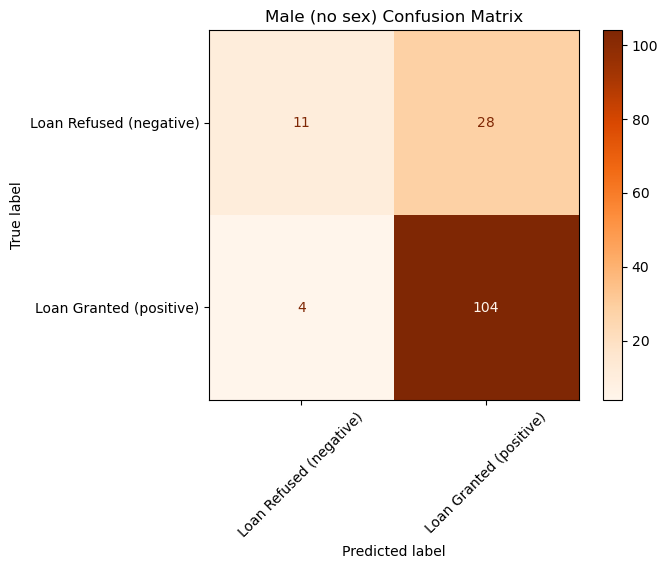

In [35]:
# calc confusion matrix
cm = confusion_matrix(male_test_results_nosex[Y], male_test_results_nosex[Y_hat], labels=model_nosex.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp = disp.plot(cmap='Oranges',values_format = '.0f')
plt.xticks(rotation=45)
plt.title('Male (no sex) Confusion Matrix');
plt.show()

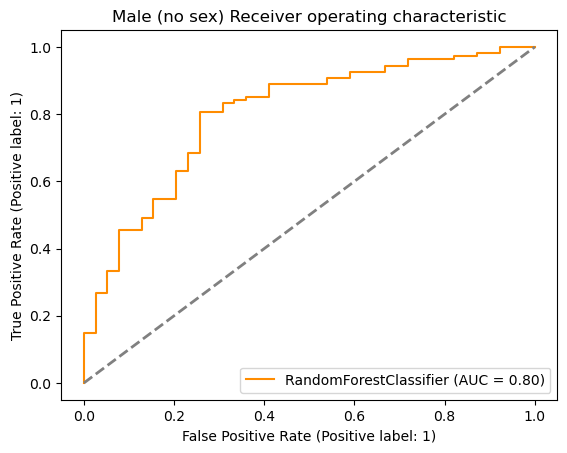

In [36]:
# calc roc
RocCurveDisplay.from_estimator(model_nosex, male_X_clean_nosex, male_test_results_nosex[Y], color='darkorange')

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.title('Male (no sex) Receiver operating characteristic')
plt.show()

In [37]:
#1. calc acc
female_nosex_acc = accuracy_score(female_test_results_nosex[Y], female_test_results_nosex[Y_hat])

print('\nModel accuracy (females) = ', female_nosex_acc)

#2. cacl f1 score
female_nosex_f1 = f1_score(female_test_results_nosex[Y], female_test_results_nosex[Y_hat])

print('Model f1 score (females) = ', female_nosex_f1)



Model accuracy (females) =  0.6792452830188679
Model f1 score (females) =  0.7901234567901234


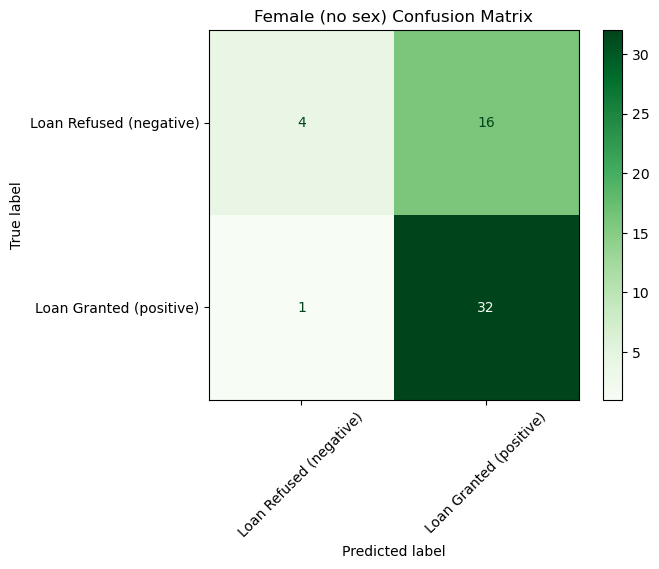

In [38]:
# calc confusion matrix
cm = confusion_matrix(female_test_results_nosex[Y], female_test_results_nosex[Y_hat], labels=model_nosex.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp = disp.plot(cmap='Greens',values_format = '.0f')
plt.xticks(rotation=45)
plt.title('Female (no sex) Confusion Matrix');
plt.show()

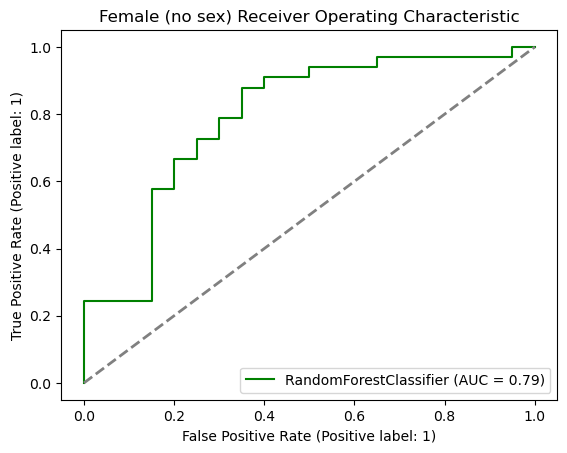

In [39]:
# calc ROC
RocCurveDisplay.from_estimator(model_nosex, female_X_clean_nosex, female_test_results_nosex[Y], color='green')

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.title('Female (no sex) Receiver Operating Characteristic')
plt.show() 

## 3.4 Test the Unaware Model for Fairness

Test the model for fairness under the relaxed conditions of the four-fifths rule.

TO-DO:

- Calculate demographic parity for positive condition
    - Calculate `Pr_male_nosex_CP` the probability of a Condition Positive for a Male , $Pr(\hat{Y} = 1| A = 1)$
    - Calculate `Pr_female_nosex_CP` the probability of a Condition Positive for a Female, $Pr(\hat{Y} = 1 | A = 0)$
- Use your function `Relax_equal` to test for parity under four-fifths rule.

In [40]:
#1. calc male CP
male_nosex_CP = len(test_results[(test_results[A] == 1) & (test_results[Y_hat] == 1)])
Pr_male_nosex_CP = male_nosex_CP/total_tests

#2. calc feamle CP
female_nosex_CP = len(test_results[(test_results[A] == 0) & (test_results[Y_hat] == 1)])
Pr_female_nosex_CP = female_nosex_CP/total_tests

#3. calc parity under four-fifths
nosex_demo_parity = Relax_equal(0.2,male_nosex_CP,female_nosex_CP)

print('Pr_male_nosex_CP',Pr_male_nosex_CP)
print('Pr_female_nosex_CP',Pr_female_nosex_CP)
print('Demographic Parity =',nosex_demo_parity)

Ratio  0.36363636363636365
Pr_male_nosex_CP 0.66
Pr_female_nosex_CP 0.24
Demographic Parity = False


In [41]:
# calc male pos odds
male_nosex_TP = len(test_results[(test_results[A] == 1) & (test_results[Y] == 1) & (test_results[Y_hat] == 1)])
male_nosex_pos_odds = male_nosex_TP/male_nosex_CP

# calc female pos odds
female_nosex_TP = len(test_results[(test_results[A] == 0) & (test_results[Y] == 1) & (test_results[Y_hat] == 1)])
female_nosex_pos_odds = female_nosex_TP/female_nosex_CP

# test for equal opp under four-fifths
nosex_equal_opp = Relax_equal(0.2,male_nosex_pos_odds,female_nosex_pos_odds)

print('male_nosex_pos_odds',male_nosex_pos_odds)
print('female_nosex_pos_odds',female_nosex_pos_odds)
print('Equal Oppertuniy (no sex) =', nosex_equal_opp)

Ratio  0.8461538461538461
male_nosex_pos_odds 0.7878787878787878
female_nosex_pos_odds 0.6666666666666666
Equal Oppertuniy (no sex) = True


### 3.4.1 What changed for the Unaware Model?

In [44]:
print(test_results[test_results['pred_Y'] != test_results[Y_hat]])

     creditamount  duration  installmentrate  residencesince  age  \
17           8072        30                2               3   25   
189          3244        18                1               4   33   
711          1198         6                4               4   35   
597          4241        24                1               4   36   
216          3104        18                3               1   31   
783           836        12                4               2   23   

     existingcredits  peopleliable  existingchecking  credithistory  purpose  \
17                 3             1                 0              0        9   
189                2             1                 1              0        3   
711                1             1                 0              1        7   
597                3             1                 1              0        9   
216                1             1                 0              0        9   
783                1             1  

In [45]:
print(test_results[(test_results['pred_Y'] != test_results[Y_hat]) & (test_results[Y_hat] == test_results['classification'])])

     creditamount  duration  installmentrate  residencesince  age  \
597          4241        24                1               4   36   
216          3104        18                3               1   31   
783           836        12                4               2   23   

     existingcredits  peopleliable  existingchecking  credithistory  purpose  \
597                3             1                 1              0        9   
216                1             1                 0              0        9   
783                1             1                 1              2        0   

     ...  property  otherinstallmentplans  housing  job  telephone  \
597  ...         0                      2        1    1          1   
216  ...         1                      0        1    2          1   
783  ...         1                      0        1    1          0   

     foreignworker  classification  pred_Y  Sex_code  pred_Y_nosex  
597              0               0       1         1

# 4. Critical Analysis, Reflection & Discussion

1. From your observations is demographic parity a fairness standard we should hold financial institutions to when handing out loans?
> It ensures a fair outcomes. Ideally we want fair treatment for different demographies, especially when handing out a loan.

2. Can you think of a real-world context within which demographic parity should be applied?
> Right to equal oppertinuty for all demogrphies, especially gender, such that gender does not play a role in decision making or providing oppertunity. Another example would be ageism, where older people are discriminated against in favor of younger ones - especially in tech jobs, where it's assumed young people may be more familiar with latest technologies.

3. From your observations comment on the effectiveness of fairness through unawareness in the context of issuing loans.
    - did it make a significant difference to the performance of the algorithm?
    >  No, it didn't make any meaningful impact, if any impact at all, on the performace as can be evidenced from accuracy and F1 score of the vanilla and modified (unaware) models - since both are very close to each other for male and female demography.
    - did it make a significant difference the the fairness of the algorithm?
    > Yes, it did. The unaware mode is more likely to grant loans to females. In fact on an equal footing to male applicants.

4. Do you think either of your models are fair?
    - Why
    > For the fairness criteria we are using, I do believe our unaware model is fair simply because it can be clearly observed that it's giving equal opportunities to females compared to males. However for a general application, it is difficult to determine as fairness is a highly subjective term.
    
5. Do you think your unaware model may still be unfair (across sex) given there is no direct causal relationship to sex. Why?
> Sex should not be a determinative criteria in such a decision, however, it is an excellent question to posit - if model does not evaluvate a criteria can it be fair with respect to that variable? If the other discriminatory patterns still exist in the data, it may still be unfair without having a direct relationship to sex variable.